# recommendations using machine learning - Task 3

In [15]:
# import the required libraries 
import pandas as pd     
import pyxlsb           
import numpy as np      
import matplotlib.pyplot as plt
import plotly 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

In [17]:
df = pd.read_excel("stc TV Data Set_T3.xlsx",index_col=0)

In [18]:
# check the data shape
df.shape

(1048575, 5)

In [19]:
# display the first 5 rows 
df.head()

,user_id_maped,program_name,rating,date_,program_genre
0,26138,100 treets,1,2017-05-27,Drama
1,7946,Moana,1,2017-05-21,Animation
2,7418,The Mermaid Princess,1,2017-08-10,Animation
3,19307,The Mermaid Princess,2,2017-07-26,Animation
4,15860,Churchill,2,2017-07-07,Biography


In [20]:
# describe the numeric values in the dataset
df.describe()

,user_id_maped,rating,date_
count,1.048575e+06,1.048575e+06,1048575
mean,1.709266e+04,2.497283e+00,2017-10-04 00:23:20.346183936
min,1.000000e+00,1.000000e+00,2017-03-14 00:00:00
25%,8.253000e+03,1.000000e+00,2017-06-10 00:00:00
50%,1.714900e+04,2.000000e+00,2017-10-14 00:00:00
75%,2.566500e+04,3.000000e+00,2018-01-21 00:00:00
max,3.428000e+04,4.000000e+00,2018-04-30 00:00:00
std,1.003513e+04,1.119837e+00,NaN


In [21]:
# check if any column has null value in the dataset
df.isnull().any()

user_id_maped    False
program_name     False
rating           False
date_            False
program_genre    False
dtype: bool

In [23]:
print(df.isnull().sum())

user_id_maped    0
program_name     0
rating           0
date_            0
program_genre    0
dtype: int64


## user recommendation model based on the viewing preferences

In [43]:
# Task 1: Build a user-to-user recommendation model

user_program_matrix = df.pivot_table(index='user_id_maped', columns='program_name', values='rating').fillna(0)

print("\nUser-Program Matrix Shape:", user_program_matrix.shape)

user_similarity = cosine_similarity(user_program_matrix)

user_similarity_df = pd.DataFrame(user_similarity, index=user_program_matrix.index, columns=user_program_matrix.index)

print(user_similarity_df.iloc[:5, :5])

def recommend_programs(user_id, user_program_matrix, user_similarity_df, num_recommendations=5, top_n_similar_users=20):
   
    if user_id not in user_similarity_df.index:
        print(f"Error: User ID {user_id} not found in the dataset.")
        return []

    similar_users = user_similarity_df[user_id].sort_values(ascending=False).drop(user_id)

    top_similar_users = similar_users[similar_users > 0].head(top_n_similar_users)
    user_watched_programs = set(user_program_matrix.loc[user_id][user_program_matrix.loc[user_id] > 0].index)
    recommendations_score = {}
    for sim_user, sim_score in top_similar_users.items():
        sim_user_programs = user_program_matrix.loc[sim_user][user_program_matrix.loc[sim_user] > 0]

        for program, rating in sim_user_programs.items():
            if program not in user_watched_programs:
                if program not in recommendations_score:
                    recommendations_score[program] = 0
                recommendations_score[program] += rating * sim_score

    sorted_recommendations = sorted(recommendations_score.items(), key=lambda x: x[1], reverse=True)

    return [program for program, score in sorted_recommendations[:num_recommendations]]

sample_user_ids = [user_program_matrix.index[0], user_program_matrix.index[1], user_program_matrix.index[2]] # Example: first 3 users

for user_id in sample_user_ids:
    print(f"\nRecommendations for User ID {user_id}:")
    recs = recommend_programs(user_id, user_program_matrix, user_similarity_df, num_recommendations=5)
    if recs:
        for i, rec in enumerate(recs):
            print(f"{i+1}. {rec}")
    else:
        print("No recommendations found for this user, or user has watched all relevant programs.")


User-Program Matrix Shape: (11578, 8013)
user_id_maped        1         5         9         11        15
user_id_maped                                                  
1              1.000000  0.059858  0.085017  0.025987  0.010245
5              0.059858  1.000000  0.000000  0.050749  0.000000
9              0.085017  0.000000  1.000000  0.044739  0.041433
11             0.025987  0.050749  0.044739  1.000000  0.021150
15             0.010245  0.000000  0.041433  0.021150  1.000000

Recommendations for User ID 1:
1. Alien: Covenant
2. Snatched
3. Collateral Beauty
4. Table
5. The Hunter's Prayer

Recommendations for User ID 5:
1. Toytoons  Ep.
2. Youm Maloosh Lazma
3. Angelo Rules
4. Cars
5. Mumuhug

Recommendations for User ID 9:
1. The Mermaid Princess
2. Tad the Lost Explorer
3. The Jetsons & WWE: Robo-WrestleMania!
4. Surf's Up : WaveMania
5. The Adventures of Petey and Friends


## Distribution Of Ratings

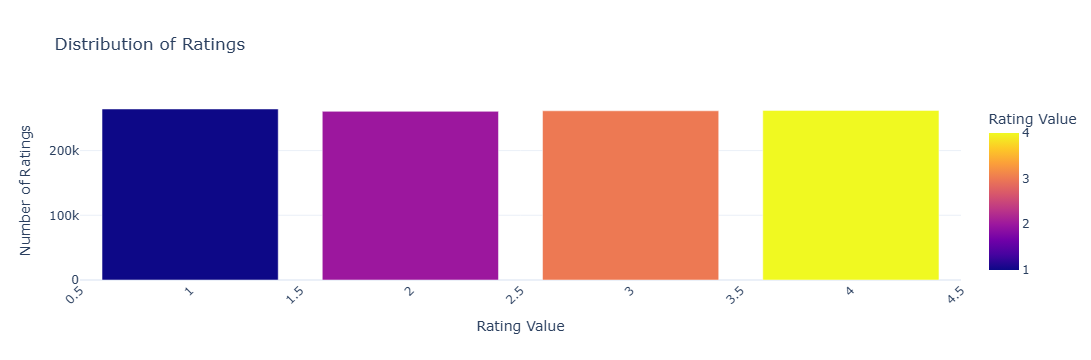

In [29]:
rating_counts = df['rating'].value_counts().sort_index()

rating_distribution = pd.DataFrame({
    'Rating': rating_counts.index,
    'Count': rating_counts.values
})

fig = px.bar(rating_distribution,
             x='Rating',
             y='Count',
             title='Distribution of Ratings',
             labels={'Rating': 'Rating Value', 'Count': 'Number of Ratings'},
             color='Rating', 
             template='plotly_white')

fig.update_layout(xaxis_title="Rating Value",
                  yaxis_title="Number of Ratings",
                  xaxis_tickangle=-45) 

fig.show()

## Top Most Watched Programs

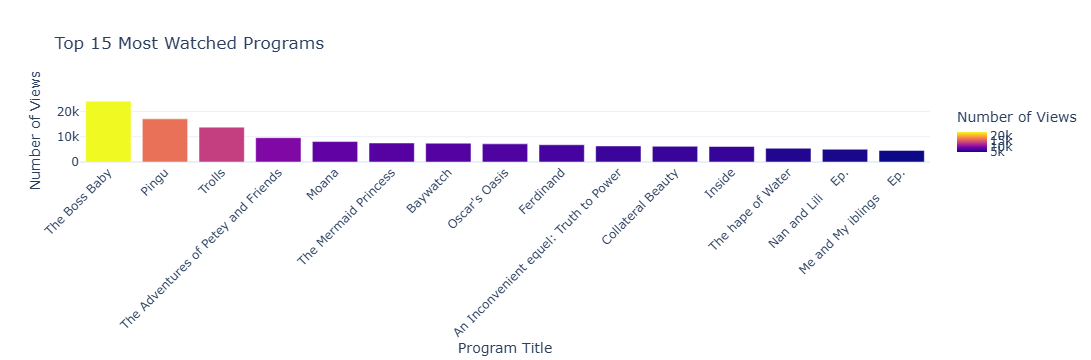

In [31]:
top_n = 15 
most_watched_programs = df['program_name'].value_counts().head(top_n)

most_watched_programs_df = pd.DataFrame({
    'Program Name': most_watched_programs.index,
    'Watch Count': most_watched_programs.values
})

fig = px.bar(most_watched_programs_df,
             x='Program Name',
             y='Watch Count',
             title=f'Top {top_n} Most Watched Programs',
             labels={'Program Name': 'Program Title', 'Watch Count': 'Number of Views'},
             color='Watch Count', 
             template='plotly_white') 
fig.update_layout(xaxis_title="Program Title",
                  yaxis_title="Number of Views",
                  xaxis_tickangle=-45) 

fig.show()

## Distribution Of Program Genres

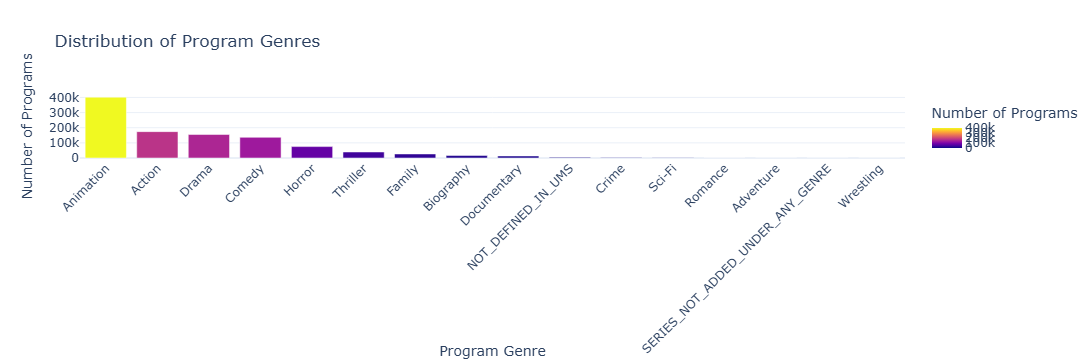

In [37]:
genre_counts = df['program_genre'].value_counts()

genre_distribution = pd.DataFrame({
    'Genre': genre_counts.index,
    'Count': genre_counts.values
})

fig = px.bar(genre_distribution,
             x='Genre',
             y='Count',
             title='Distribution of Program Genres',
             labels={'Genre': 'Program Genre', 'Count': 'Number of Programs'},
             color='Count', 
             template='plotly_white') 

fig.update_layout(xaxis_title="Program Genre",
                  yaxis_title="Number of Programs",
                  xaxis_tickangle=-45) 
fig.show()

In [38]:
# Task 2: Top 5 Recommendations for people who watched 'Moana' movie

moana_watchers_ids = df[df['program_name'] == 'Moana']['user_id_maped'].unique()

print(f"Number of unique users who watched 'Moana': {len(moana_watchers_ids)}")

all_moana_recommendations_list = []
for user_id in moana_watchers_ids:
    recs = recommend_programs(user_id, user_program_matrix, user_similarity_df, num_recommendations=10)
    all_moana_recommendations_list.extend(recs)

recommendation_counts = Counter(all_moana_recommendations_list)

top_5_moana_recs = recommendation_counts.most_common(5)

print("Top 5 Recommendations for people who watched 'Moana':")
if top_5_moana_recs:
    for i, (program, count) in enumerate(top_5_moana_recs):
        print(f"{i+1}. {program} (Recommended {count} times)")
else:
    print("No common recommendations found for Moana watchers.")

Number of unique users who watched 'Moana': 2173
Top 5 Recommendations for people who watched 'Moana':
1. Surf's Up : WaveMania (Recommended 567 times)
2. Collateral Beauty (Recommended 566 times)
3. Rings (Recommended 519 times)
4. The Jetsons & WWE: Robo-WrestleMania! (Recommended 474 times)
5. Storks (Recommended 456 times)


## Top 5 Programs Recommeded to "Moana" Watchers

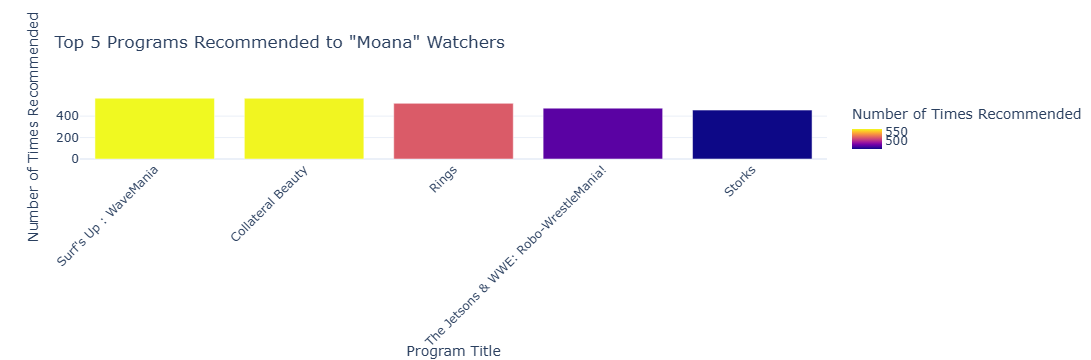

In [40]:
moana_watchers_ids = df[df['program_name'] == 'Moana']['user_id_maped'].unique()

all_moana_recommendations_list = []
for user_id in moana_watchers_ids:
    recs = recommend_programs(user_id, user_program_matrix, user_similarity_df, num_recommendations=10)
    all_moana_recommendations_list.extend(recs)

recommendation_counts = Counter(all_moana_recommendations_list)
top_5_moana_recs = recommendation_counts.most_common(5)

moana_recs_df = pd.DataFrame(top_5_moana_recs, columns=['Program Name', 'Recommended Count'])

moana_recs_df = moana_recs_df.sort_values(by='Recommended Count', ascending=False)

fig = px.bar(moana_recs_df,
             x='Program Name',
             y='Recommended Count',
             title='Top 5 Programs Recommended to "Moana" Watchers',
             labels={'Program Name': 'Program Title', 'Recommended Count': 'Number of Times Recommended'},
             color='Recommended Count', 
             template='plotly_white')
fig.update_layout(xaxis_title="Program Title",
                  yaxis_title="Number of Times Recommended",
                  xaxis_tickangle=-45) 
fig.show()

In [42]:
df.head()

,user_id_maped,program_name,rating,date_,program_genre
0,26138,100 treets,1,2017-05-27,Drama
1,7946,Moana,1,2017-05-21,Animation
2,7418,The Mermaid Princess,1,2017-08-10,Animation
3,19307,The Mermaid Princess,2,2017-07-26,Animation
4,15860,Churchill,2,2017-07-07,Biography
